In [1]:
fpath = "/home/stc/devspace/codes/SpinEchoSim/"

# CPU
include(join([fpath,"SpinEchoSim_cpu.jl"]))

# GPU
#using CUDA
#include(join([fpath,"SpinEchoSim_gpu.jl"]))

In [4]:
### setup the job

# make the parameter file
params = make_params()

# Jobs: Gaussian, Power, RKKY, AFM Power, P_power, d_power

# interaction
params["α"] = LinRange(0.0,0.12,7)#LinRange(0.001, 0.005, 3)#[0.000,0.005,0.01];#3*0.015;
params["α_z"] = 1.0 .* params["α"]; #[0.1];
#params["α_fac"] = [0.5,2,1,6,8,6];
#params["α_fac"] = [1,1,1,1,1,1];
#params["M_op"] = params["Iy"]

# number of frequencies
params["n"] = (40, 40)

params["τ"] = convert.(Float32,100e-6)
params["dt"] = convert.(Float32, 1)
#params["line_width"] = 0.01
#params["bw"] = 0.1

# make a lattice, pbc = periodic bc or not
params["hlk"] = [1; 1]
params["θ"] = [π/2]
params["r"], params["spin_idx"] = make_lattice(params["hlk"], params["θ"], params["n"])

# make the stencil
params["ξ"] = 8
params["decay_power"] = 3

#params["func_type"] = [0,1,2,1,1,1] # 0: gauss, 1: power, 2: RKKY
#params["afm"] = [false, false, false, true, false, false];
#params["s_w"] = [1.0, 1.0, 1.0, 1.0, 0.0, 0.0];
#params["p_w"] = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0];
#params["d_w"] = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0];

params["func_type"] = 0 # 0: gauss, 1: power, 2: RKKY, 3: uniform
params["afm"] = false;
params["s_w"] = 1.0
params["p_w"] = 0.0
params["d_w"] = 0.0

func_type = 3;    
params["M_stencil"] = make_stencil(params["r"], params["ξ"], params["decay_power"],func_type)
# dissipation parameters
params["Γ"] = (0, 0, 10^-7);

# load the pulsing parameters
params["flip_angle"] = LinRange(0.2,1.8,7) .* π/2;
params["phases"] = (0, π/2)

# cpmg parameters
params["echo_time"] = 100e-6 # collect(LinRange(50e-6, 300e-6, 20));
params["num_echoes"] = convert.(Int64, round.(1000e-6./params["echo_time"]));

# set the variables
#vars = ["α",("α_fac","func_type","afm","s_w","p_w","d_w")]
vars = [("α","α_z"),"flip_angle"]
params["vars"] = vars;

# generate indexing (needed for temp_params function)
I, d = make_idx(vars, params);

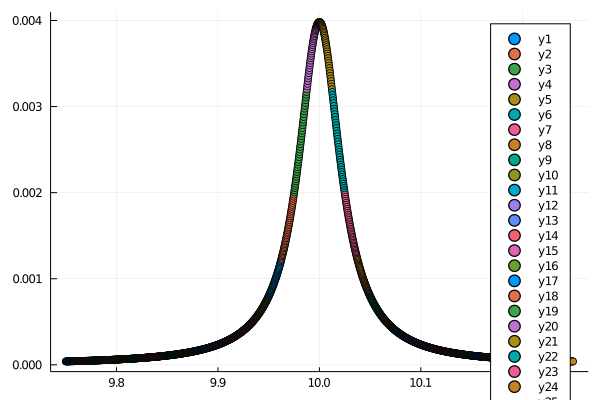

In [5]:
using Plots

tparams = make_temp_params(params, vars, I[1]);
scatter(tparams["ν"],tparams["P"])
#histogram( broadcast(real,tparams["ν"][:]),bins=300)

In [6]:
# simulate
M = Array{Any}(undef,size(I))
Mv = Array{Any}(undef,size(I))

for idx in I
    # generate temporary parameters
    tparams = make_temp_params(params, vars, idx);
    #tparams["M_stencil"] = make_stencil(tparams["r"], tparams["ξ"], tparams["decay_power"],tparams["func_type"],tparams["afm"],tparams["s_w"],tparams["p_w"],tparams["d_w"])
    #tparams["ν"] = tparams["ν"] .+ 0.1;
    @time M[idx], Mv[idx] = spin_echo_sim_liouville(tparams);        
    #@time M[idx] = spin_echo_sim(tparams);        

end
println("done!")

 99.315258 seconds (86.52 M allocations: 331.046 GiB, 10.75% gc time)
 87.524583 seconds (54.60 M allocations: 329.610 GiB, 11.48% gc time)
 87.864035 seconds (54.60 M allocations: 329.610 GiB, 11.67% gc time)
 89.020298 seconds (54.60 M allocations: 329.610 GiB, 11.69% gc time)
 87.870100 seconds (54.60 M allocations: 329.610 GiB, 11.74% gc time)
 87.829765 seconds (54.60 M allocations: 329.610 GiB, 11.72% gc time)
 87.896255 seconds (54.60 M allocations: 329.610 GiB, 11.73% gc time)
 87.925252 seconds (54.60 M allocations: 329.610 GiB, 11.71% gc time)
 87.826878 seconds (54.60 M allocations: 329.610 GiB, 11.71% gc time)
 87.884863 seconds (54.60 M allocations: 329.610 GiB, 11.69% gc time)
 87.939815 seconds (54.60 M allocations: 329.610 GiB, 11.65% gc time)
 87.861059 seconds (54.60 M allocations: 329.610 GiB, 11.61% gc time)
 87.846283 seconds (54.60 M allocations: 329.610 GiB, 11.65% gc time)
 88.059809 seconds (54.60 M allocations: 329.610 GiB, 11.66% gc time)
 87.943846 seconds (

In [9]:
using Plots
p = Vector{Any}(undef,size(M)[2])
N = 1;#prod(size(params["r"]));
dh = 0.5;
t_max = 3.0*params["τ"]*1e6


for run_idx in 1:size(M)[2]
    p[run_idx] = plot()
    for alpha_idx in 1:size(M)[1]
        t = LinRange(0, t_max, size(M[alpha_idx,run_idx], 1));

        p[run_idx] = plot!(t,broadcast(real,M[alpha_idx,run_idx])/N .+ dh*(alpha_idx-1),linecolor=:red)
        p[run_idx] = plot!(t,broadcast(imag,M[alpha_idx,run_idx])/N .+ dh*(alpha_idx-1),linecolor=:blue)
        p[run_idx] = plot!([0,t_max], dh*(alpha_idx-1) .+ [0,0], linecolor=:black, linestyle=:dash)
    end
end

#plot(p[1],p[2],p[3],legend=false,size=(400,500))
plot(p[1],p[2],p[3],p[4],p[5],p[6],p[7],layout=(1,7),legend=false,size=(1200,300))


In [13]:
using FFTW

plt1 = plot()
plt2 = plot()
plt3 = plot()
plt4 = plot()
ν0 = params["ν0"]

t_max = 2*params["τ"]*1e6; # 200 micro seconds
f = params["flip_angle"];

dt_start = 0;
dt_end = dt_start;

M0 = convert(Array{Complex{Float64}},M[1,1])
nt = size(M0, 1)

# select a truncated window to FFT
M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
ntrunc = size(M0_trunc,1)
t = LinRange(0, t_max, size(M0_trunc, 1))
dt = t[2]-t[1]
t_envelope = 1 ./(1 .+ exp.(-0.1 .* (t .- 120)))
t_envelope = t_envelope .* reverse(t_envelope)

zn = 13;
zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)

# figure out the "frequency axis" after the FFT
Fs = 1/dt;
N = size(zero_pad,1)
freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;

# loop over the corr. strengths
alpha_list = params["α"]
run_idx = 4
for alpha_idx in 1:size(M)[1]

    # load in the M data
    M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])

    # select a truncated window to FFT
    M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
    M0_trunc_z = zero_pad
    M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc
    
    ang_here = (f[run_idx]*180/π);
    ang_str = string(round(ang_here),"°");

    # labeling
    alpha_str = string(round(alpha_list[alpha_idx],digits=2))
    color_here = RGB(alpha_idx/length(alpha_list),1-alpha_idx/length(alpha_list),0.5)

    # plot the time-domain results
    M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
    M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
    plot!(plt1,t, M0_trunc_abs .+ 2*(alpha_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    plot!(plt1,t, 0*M0_trunc_abs .+ 2*(alpha_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

    # FFT!
    M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

    M0_fft = M0_fft/maximum(broadcast(abs,broadcast(imag,M0_fft))) # normalize
    #plot!(plt2,ν0 .+ [0,0],[0, (2*length(alpha_list))],color=RGB(0,0,0),label="",linestyle=:dot,linewidth=.2)

    plot!(plt2,freq_ax .+ ν0, 0*broadcast(imag,M0_fft) .+ 2*(alpha_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")
    plot!(plt2,freq_ax .+ ν0,   broadcast(abs,broadcast(imag,M0_fft)) .+ 2*(alpha_idx-1),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

    annotate!(plt2,10.225,0.7+2*(alpha_idx-1),text(alpha_str,color_here, :right,8))

    if (alpha_idx == 1)
        #annotate!(plt2, 10.05, 0.25 + 2*(alpha_idx-1),text(ang_str,color_here, :left,12)) 
    end

end

# pulse sweep
for run_idx in 1:size(M)[2]
    alpha_idx = 4;
    # load in the M data
    M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])

    # select a truncated window to FFT
    M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
    M0_trunc_z = zero_pad
    M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc
    
    ang_here = (f[run_idx]*180/π);
    ang_str = string(round(ang_here),"°");

    # labeling
    alpha_str = string(round(alpha_list[alpha_idx],digits=4))
    c_x = (run_idx-size(M)[2]/2)/size(M)[2]
    color_here = RGB(0.5+.5*c_x,0.5,0.5-c_x)
    # plot the time-domian results
    M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
    M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
    plot!(plt3,t, M0_trunc_abs .+ 2*(run_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    plot!(plt3,t, 0*M0_trunc_abs .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

    # FFT!
    M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

    M0_fft = M0_fft/maximum(broadcast(abs,broadcast(abs,M0_fft))) # normalize
    #plot!(plt4,ν0 .+ [0,0],[0, 2*size(M)[2]],color=RGB(0,0,0),label="",linestyle=:dot,linewidth=.2)

    plot!(plt4,freq_ax .+ ν0, 0*broadcast(imag,M0_fft) .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")
    plot!(plt4,freq_ax .+ ν0,   broadcast(abs,broadcast(abs,M0_fft)) .+ 2*(run_idx-1),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

    if (run_idx == 1)
        #annotate!(plt2,11.15,0.5+2*(alpha_idx-1),text(alpha_str,color_here, :right,12))
    end
    if true#(run_idx == 1 || run_idx == 4 || run_idx == 7)
        annotate!(plt4,10.1,+0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))
    end
end

ylabel!(plt1,"|M|")
#ylabel!(plt3,"|M|")

xlabel!(plt1,"time (μs)")
xlabel!(plt3,"time (μs)")

xlabel!(plt2,"frequency (MHz)")
xlabel!(plt4,"frequency (MHz)")

plot!(plt1,ylim=[0, 14])
plot!(plt3,ylim=[0, 14])

time_ax = [75,125]

plot!(plt1,xlim=time_ax,xticks=[80,100,120])
plot!(plt3,xlim=time_ax,xticks=[80,100,120])

plot!(plt2,ylim=[0, 14])
plot!(plt4,ylim=[0, 14])

freq_ax = [9.8, 10.2]

plot!(plt2,xlim=freq_ax,xticks=[9.8,10,10.2])
plot!(plt4,xlim=freq_ax,xticks=[9.8,10,10.2])

plot!(plt1,yticks=[])
plot!(plt2,yticks=[])
plot!(plt3,yticks=[])
plot!(plt4,yticks=[])

#title!(plt1,L"\textrm{Signal (rotating frame)}")
#title!(plt2,L"\textrm{Spectrum}")

fig_x = 60*10;
fig_y = 35*10;
plot(plt1,plt2,plt3,plt4,layout=(1,4),size=(fig_x,fig_y))
savefig("alpha_and_power_sweep_abs_10-04-2021.pdf")

In [8]:
using JLD2
#@save "prl_fig1_angle_alpha_sweep_10-04-2021.jld2"
@load "prl_fig1_angle_alpha_sweep_10-04-2021.jld2"

10-element Array{Symbol,1}:
 Symbol("#1#2")
 :I            
 :M            
 :Mv           
 :d            
 :fpath        
 :func_type    
 :params       
 :tparams      
 :vars         